# Dataset

1. **inputs_weather_train.npy**: For each record, daily weather data - a total of 214 days spanning the crop growing season (defined April 1 through October 31). Daily weather records were compiled based on the nearest grid point from a gridded 30km product. Each day is represented by the following 7 weather variables - 
- Average Direct Normal Irradiance (ADNI)
- Average Precipitation (AP)
- Average Relative Humidity (ARH)
- Maximum Direct Normal Irradiance (MDNI)
- Maximum Surface Temperature (MaxSur)
- Minimum Surface Temperature (MinSur)
- Average Surface Temperature (AvgSur)

2. **inputs_others_train.npy**: Maturity Group (MG), Genotype ID, State, Year, and Location for each performance record.

3. **yield_train.npy**: Yearly crop yield value for each record.

We provide genotype clustering information in clusterID_genotype.npy. The file contains cluster ID for each of the 5839 genotypes. Participants may or may not use this information. We developed a completely connected pedigree for all lines with available parentage information, resulting in the formation of a 5839 x 5839 correlation matrix. 

**Feel free to use external datasets for the competition**. For the reproducibility of the results and prize money distribution, the top three teams must provide the open-source code and any external datasets used for the competition.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy.random import seed
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import graphviz
from datetime import date
import time
import pyreadr

import os

import joblib

# Load data

In [2]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
MG = MG.reshape(-1,1)
MG = MG.astype(float).astype(int)

# Transform Genotype into ClusterID
# Genotype = df_train['Genotype'].astype('category')
# Genotype = Genotype.to_numpy()
# Genotype = Genotype.astype(float).astype(int)
# K = np.empty(len(Genotype))
# for i in range(len(ClusterID)):
#     K[Genotype==i] = ClusterID[i]
# K = K.reshape(-1,1)
# K = K.astype(int)

# Standardization prcess
scaler_x0 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,1])
scaled_x1 = scaler_x1.transform(Weather_train[:,:,1])
scaler_x2 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,2])
scaled_x2 = scaler_x2.transform(Weather_train[:,:,2])
scaler_x3 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,3])
scaled_x3 = scaler_x3.transform(Weather_train[:,:,3])
scaler_x4 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,4])
scaled_x4 = scaler_x4.transform(Weather_train[:,:,4])
scaler_x5 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,5])
scaled_x5 = scaler_x5.transform(Weather_train[:,:,5])
scaler_x6 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,6])
scaled_x6 = scaler_x6.transform(Weather_train[:,:,6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])

# Transform into series data
print(X.shape)

X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))

print(X.shape)

X = np.hstack((X, MG))
# X = np.hstack((X, MG, K))

#####################################
# Load training and validation data #
#####################################
# 10% is test, 10% is val, 80% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.2, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''
df_test = np.load('./Dataset_Competition/Test Inputs/inputs_others_test.npy')
df_test = pd.DataFrame(df_test, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))

(93028, 214, 7)
(93028, 1498)


In [3]:
# CHECK the number of genotypes, AFTER concatinating train and test
df = pd.concat([df_train, df_test], axis=0)
print(len(np.unique(df['Genotype'])))
np.unique(df['Genotype'])

5838


array(['1.0', '10.0', '100.0', ..., '997.0', '998.0', '999.0'],
      dtype=object)

# Random Forest Parameter Tuning - CV
Repeated 10-fold CV for training dataset (Repeated for 3 times)

- First trial (2021-09-27): \
Without ClusterID\
grid = [
    {'n_estimators': [64, 128, 258, 512]},
    {'max_features': [2, 4, 8, 16, 32, 64, 128]}
] \
15024.463 seconds \
512


- Second trial (2021-09-28): \
With ClusterID\
grid = [{'n_estimators': [128, 258, 512, 1024]}] \
31081.255 seconds \
1024


In [4]:
import multiprocessing
cpu_num = multiprocessing.cpu_count()
print(cpu_num)

from time import time
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# define the model
model = RandomForestRegressor(n_jobs=1)

36


In [ ]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# define grid
# grid = dict()
# grid['max_features'] = [1, 2, 3, 4, 5]

# 1st trial
# grid = [
#     {'n_estimators': [64, 128, 258, 512]},
#     {'max_features': [2, 4, 8, 16, 32, 64, 128]}
# ]

grid = [
    {'n_estimators': [258, 512, 1024, 2048]}
]


# define grid search
search = GridSearchCV(model, grid, n_jobs=cpu_num, cv=cv)

# record current time
start = time()

# perform search
search.fit(X_train,Y_train)

# record current time
end = time()

# report execution time
result = end - start
print('%.3f seconds' % result)

In [ ]:
# Best parameter
search.best_params_

In [ ]:
# All scores
search.set_params


# Retrain the model using the optimized parameters

In [5]:
model = RandomForestRegressor(n_estimators=1024, n_jobs=18)
model.fit(X_train,Y_train)
joblib.dump(model, "./model_scikit/random_forest.joblib")

['./model_scikit/random_forest.joblib']

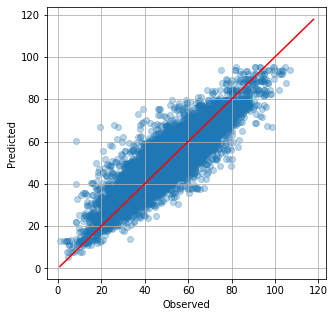

Test RMSE: 7.24
Test MAE: 5.43
Test R2: 0.796


In [6]:
pred_test = model.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(Y_test, pred_test, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_test).item(), 1.1*max(Y_test).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Test RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_test, pred_test))))
print("Test MAE: %.2f" % (mean_absolute_error(Y_test, pred_test)))
print("Test R2: %.3f" % (r2_score(Y_test, pred_test)))